<a href="https://colab.research.google.com/github/IvanShc/Data_analysis_lab1/blob/main/Lab1_rizn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU")
else:
    print("CPU")

GPU


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
import kagglehub
from sklearn.model_selection import train_test_split

In [ ]:
IMG_SIZE = (32, 32)
BATCH_SIZE = 32
DATA_DIR = 'kaggle/input/animals10/train'

# Завантаження даних

Шлях, отриманий від kagglehub.dataset_download: /kaggle/input/animals10
Отримано шлях до директорії: /kaggle/input/animals10. Розпакування не потрібне.
Назви класів: ['собака', 'кінь', 'слон', 'метелик', 'курка', 'кіт', 'корова', 'вівця', 'павук', 'білка']
Мапування папок на мітки: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
Завантаження та обробка зображень
Обробка класу: собака (папка: cane)
Завантажено 4863 зображень для класу 'собака'
Обробка класу: кінь (папка: cavallo)
Завантажено 2623 зображень для класу 'кінь'
Обробка класу: слон (папка: elefante)
Завантажено 1446 зображень для класу 'слон'
Обробка класу: метелик (папка: farfalla)
Завантажено 2112 зображень для класу 'метелик'
Обробка класу: курка (папка: gallina)
Завантажено 3098 зображень для класу 'курка'
Обробка класу: кіт (папка: gatto)
Завантажено 1668 зображень для класу 'кіт'
Обробка класу: корова (папка: mucca)
Завантажено 1866 

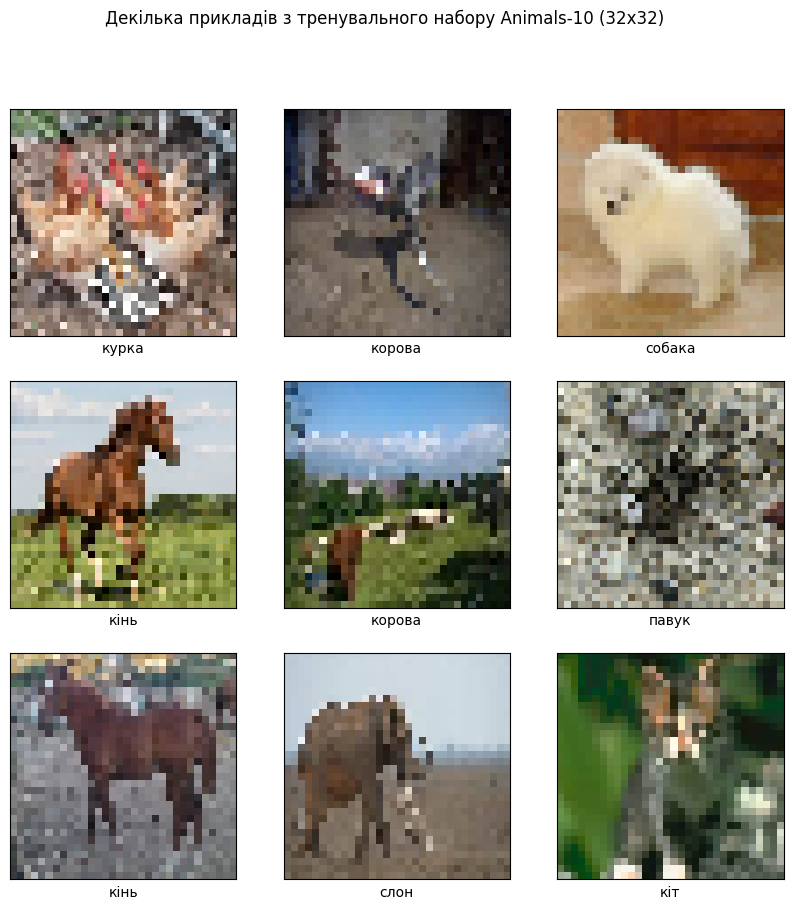

In [ ]:
try:
    downloaded_path = kagglehub.dataset_download("alessiocorrado99/animals10")
    print(f"Шлях, отриманий від kagglehub.dataset_download: {downloaded_path}")

    main_image_folder = ""

    if os.path.isdir(downloaded_path):
        print(f"Отримано шлях до директорії: {downloaded_path}. Розпакування не потрібне.")
        main_image_folder = os.path.join(downloaded_path, 'raw-img')

        if not os.path.isdir(main_image_folder):
            raise FileNotFoundError(
                f"Очікувана папка 'raw-img' не знайдена всередині '{downloaded_path}'. "
                f"Перевірте структуру. Вміст '{downloaded_path}': {os.listdir(downloaded_path)}"
            )
    if not os.path.isdir(main_image_folder):
         raise FileNotFoundError(f"Папка з зображеннями '{main_image_folder}' не існує або не є директорією.")

    original_italian_folders = [
        "farfalla", "gatto", "gallina", "mucca", "cane",
        "elefante", "cavallo", "ragno", "pecora", "scoiattolo"
    ]

    italian_folder_names_ordered = sorted(original_italian_folders)

    class_names_ua_map = {
        "farfalla": "метелик",
        "gatto": "кіт",
        "gallina": "курка",
        "mucca": "корова",
        "cane": "собака",
        "elefante": "слон",
        "cavallo": "кінь",
        "ragno": "павук",
        "pecora": "вівця",
        "scoiattolo": "білка"
    }

    class_names = [class_names_ua_map[it_name] for it_name in italian_folder_names_ordered]
    folder_to_label_map = {it_name: i for i, it_name in enumerate(italian_folder_names_ordered)}

    print(f"Назви класів: {class_names}")
    print(f"Мапування папок на мітки: {folder_to_label_map}")

    all_images = []
    all_labels = []

    print("Завантаження та обробка зображень")
    for class_folder_it_name, label in folder_to_label_map.items():
        class_path = os.path.join(main_image_folder, class_folder_it_name)

        if not os.path.isdir(class_path):
            print(f"Попередження: папка класу '{class_path}' не знайдена. Пропускається.")
            continue

        ukrainian_class_name = class_names_ua_map[class_folder_it_name]
        print(f"Обробка класу: {ukrainian_class_name} (папка: {class_folder_it_name})")

        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        count = 0
        for image_name in image_files:
            image_path = os.path.join(class_path, image_name)
            try:
                img = load_img(image_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                all_images.append(img_array)
                all_labels.append(label)
                count += 1
            except Exception as e:
                print(f"Не вдалося завантажити або обробити зображення {image_path}: {e}")
        print(f"Завантажено {count} зображень для класу '{ukrainian_class_name}'")

    if not all_images:
        raise ValueError("Не було завантажено жодного зображення. Перевірте шляхи та вміст папок.")

    all_images_np = np.array(all_images)
    all_labels_np = np.array(all_labels)

    print(f"Загальна кількість завантажених зображень: {len(all_images_np)}")

    # Нормалізація зображень
    all_images_np = all_images_np / 255.0

    train_images, test_images, train_labels, test_labels = train_test_split(
        all_images_np, all_labels_np, test_size=0.2, random_state=42, stratify=all_labels_np
    )

    if train_labels.ndim > 1 and train_labels.shape[1] == 1:
        train_labels = train_labels.ravel()
    if test_labels.ndim > 1 and test_labels.shape[1] == 1:
        test_labels = test_labels.ravel()

    print(f"Розмір тренувального набору зображень: {train_images.shape}")
    print(f"Розмір тренувального набору міток: {train_labels.shape}")
    print(f"Розмір тестового набору зображень: {test_images.shape}")
    print(f"Розмір тестового набору міток: {test_labels.shape}")

    # Виведемо 9 зображень
    plt.figure(figsize=(10,10))

    for i in range(min(9, len(train_images))):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images[i])
        plt.xlabel(class_names[train_labels[i]])
    plt.suptitle("Декілька прикладів з тренувального набору Animals-10 (32x32)")
    plt.show()

except Exception as e:
    print(f"Сталася помилка {e}")

# Створення та базове навчання моделі (Feature Extraction)

In [ ]:
base_model = tf.keras.applications.ResNet50(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False


model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

initial_epochs = 10
history_base = model.fit(
    train_images,
    train_labels,
    epochs=initial_epochs,
    validation_data=(test_images, test_labels),
    batch_size=BATCH_SIZE
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.1609 - loss: 2.7020 - val_accuracy: 0.2706 - val_loss: 2.1339
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - accuracy: 0.2230 - loss: 2.1865 - val_accuracy: 0.2744 - val_loss: 2.0700
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2414 - loss: 2.1639 - val_accuracy: 0.2666 - val_loss: 2.0693
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2390 - loss: 2.1597 - val_accuracy: 0.3067 - val_loss: 2.0296
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2375 - loss: 2.1666 - val_accuracy: 0.2716 - val_loss: 2.1024
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2453 - loss: 2.1529 - val_accuracy: 0.2697 - val_loss: 2.1013
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2427 - loss: 2.1556 - val_accuracy: 0.2630 - val_loss: 2.1076
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2430 - loss: 2.1574 - val_a

#  Fine-Tuning моделі

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Архітектура моделі після розморожування:")
model.summary()



fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = model.fit(
    train_images,
    train_labels,
    epochs=total_epochs,
    initial_epoch=history_base.epoch[-1],
    validation_data=(test_images, test_labels),
    batch_size=BATCH_SIZE
)

Архітектура моделі після розморожування:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 10/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 104s 74ms/step - accuracy: 0.1397 - loss: 8.7053 - val_accuracy: 0.1163 - val_loss: 654.5964
Epoch 11/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.1724 - loss: 3.5268 - val_accuracy: 0.2319 - val_loss: 5.0891
Epoch 12/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.2095 - loss: 2.5417 - val_accuracy: 0.3008 - val_loss: 5.9713
Epoch 13/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.2633 - loss: 2.3180 - val_accuracy: 0.3449 - val_loss: 4.9334
Epoch 14/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.2984 - loss: 2.1783 - val_accuracy: 0.3703 - val_loss: 2.9616
Epoch 15/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.3456 - loss: 2.0094 - val_accuracy: 0.3994 - val_loss: 3.4747
Epoch 16/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.3703 - loss: 1.9118 - val_accuracy: 0.4274 - val_loss: 3.3253
Epoch 17/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.4133 - loss

# Оцінка, пояснення та порівняння результатів

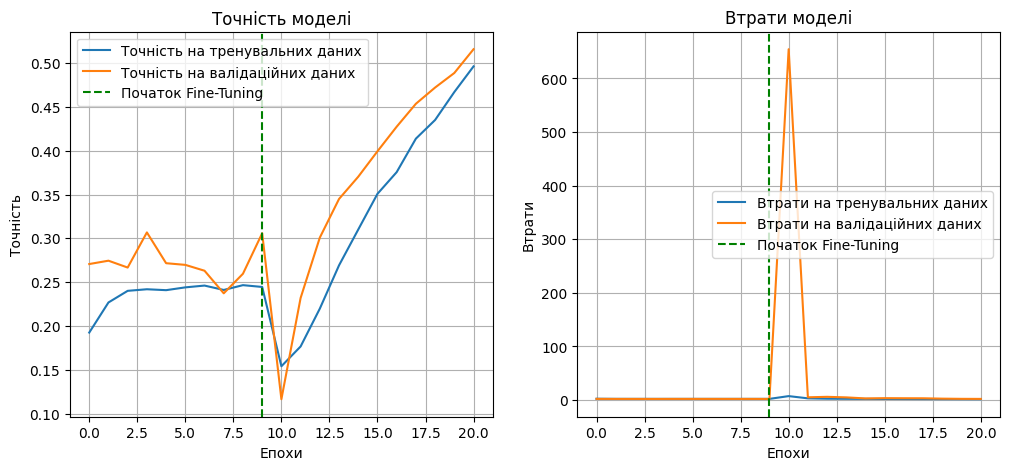

Базова точність на тестових даних: 30.58%
Фінальна точність з Fine-Tuning на тестових даних: 51.59%
Приріст точності завдяки fine-tuning: 21.01%


In [ ]:
acc = history_base.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history_base.history['val_accuracy'] + history_fine_tune.history['val_accuracy']

loss = history_base.history['loss'] + history_fine_tune.history['loss']
val_loss = history_base.history['val_loss'] + history_fine_tune.history['val_loss']


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Точність на тренувальних даних')
plt.plot(val_acc, label='Точність на валідаційних даних')
plt.axvline(x=initial_epochs-1, color='green', linestyle='--', label='Початок Fine-Tuning')
plt.title('Точність моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(loss, label='Втрати на тренувальних даних')
plt.plot(val_loss, label='Втрати на валідаційних даних')
plt.axvline(x=initial_epochs-1, color='green', linestyle='--', label='Початок Fine-Tuning')
plt.title('Втрати моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)

plt.show()


baseline_accuracy = history_base.history['val_accuracy'][-1]
fine_tuned_accuracy = history_fine_tune.history['val_accuracy'][-1]

print(f"Базова точність на тестових даних: {baseline_accuracy:.2%}")
print(f"Фінальна точність з Fine-Tuning на тестових даних: {fine_tuned_accuracy:.2%}")
print(f"Приріст точності завдяки fine-tuning: {fine_tuned_accuracy - baseline_accuracy:.2%}")

Аналіз результатів
1. Етап базового навчання:\
Поведінка моделі: На цьому етапі ми тренували лише верх класифікатора, тоді як ваги ResNet50 були заморожені. Як видно на графіку "Точність моделі", точність на валідаційних даних (помаранчева лінія) коливалася в діапазоні 25-30% і досягла фінального значення 30.58% наприкінці. Цей результат показує, що модель добре працювати, використовуючи вивчені фічі на датасеті ImageNet. Тим не менш, цього недостатньо для точної класифікації конкретних зображень з датасету.
2. Fine-Tuning\
Зелена пунктирна лінія чітко позначає момент, коли ми розморозили базову модель і почали донавчати її з низькою швидкістю навчання lr = 0.00001.
На правому графіку "Втрати моделі" видно величезний сплеск втрат на 10-й епосі. Це досить очікувана поведінка. Коли ваги базової моделі стали тренованими, навіть невеликі їх зміни на початку призвели до значного збільшення помилки. Проте модель адаптується. Одразу після цього сплеску на лівому графіку починається стабільний і значний ріст як тренувальної, так і валідаційної точності. Це головний доказ того, що fine-tuning працює. Модель почала адаптувати свої глибокі шари, щоб краще розпізнавати ознаки, характерні саме для нашого датасету тварин.

# Висновок
Метод fine-tuning виявився досить ефективним. Він дозволив покращити точність моделі з 30.58% до 51.59%, що становить значний приріст у 21.01%.\
Це наочно демонструє, що просте використання попередньо навченої моделі дає лише обмежений результат. Потужний приріст в точності розкривається під час fine tuning, коли модель отримує можливість адаптувати свої внутрішні уявлення про візуальні патерни під специфіку нового датасету.